In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("../src/")

In [2]:
import matplotsoccer as mps
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data = "../data/spadl-v2.hdf"
games = pd.read_hdf(data,key="games")
epl16 = games[(games.competition_id == 8) & (games.season_id == 2016)]
epl16[:5]

def get_actions(games, hdf_url):
    actions = []
    for game in tqdm(list(games.itertuples())):
        a = pd.read_hdf(hdf_url, key="actions/" + str(game.id))
        a["left_to_right"] = a["team_id"] == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)

    #actions = always_ltr(actions)
    return actions


def always_ltr(actions):
    away_idx = ~actions.left_to_right
    actions.loc[away_idx, "start_x"] = 105 - actions[away_idx].start_x.values
    actions.loc[away_idx, "start_y"] = 68 - actions[away_idx].start_y.values
    actions.loc[away_idx, "end_x"] = 105 - actions[away_idx].end_x.values
    actions.loc[away_idx, "end_y"] = 68 - actions[away_idx].end_y.values
    return actions

actions = get_actions(epl16,data)

actiontypes = pd.read_hdf(data, key="actiontypes")
actiontypes.columns = ["type_id","type_name"]
actions = actions.merge(actiontypes, on="type_id")

players = pd.read_hdf(data,key="players")
actions = actions.merge(players,left_on="player_id",right_on="id")

teams = pd.read_hdf(data,key="teams")
actions = actions.merge(teams,left_on="team_id",right_on="id")

actions = actions.sort_values(["game_id","period_id","time_seconds","timestamp"])

actions.columns

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
100%|██████████| 380/380 [00:04<00:00, 90.25it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart',
       'type_id', 'result', 'left_to_right', 'type_name', 'id_x', 'first_name',
       'last_name', 'soccer_name', 'birthday', 'nation_id', 'id_y',
       'full_name', 'short_name', 'abbreviation'],
      dtype='object')

In [4]:
player_actions = actions[actions.last_name.str.contains("Kompany")].copy()
set(player_actions.soccer_name)
player_actions = always_ltr(player_actions)
x,y = player_actions.start_x, player_actions.start_y

# Field

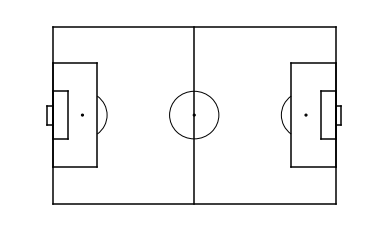

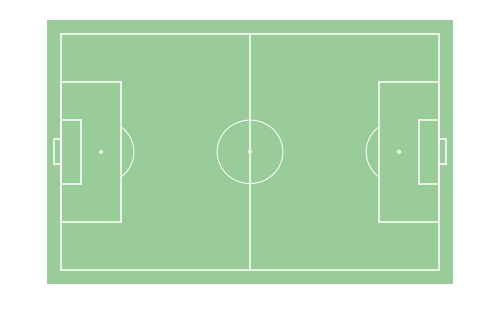

In [5]:
f = mps.field()
f = mps.field(color="green",figsize=8)

# Heatmap

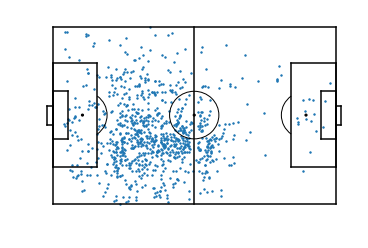

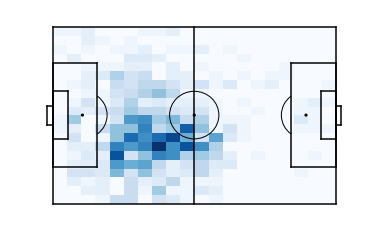

In [6]:
ax = mps.field(show=False)
ax.scatter(x,y,s=2); plt.show()

matrix = mps.count(x,y,n=20,m=20)
hm = mps.heatmap(matrix)

# Actions

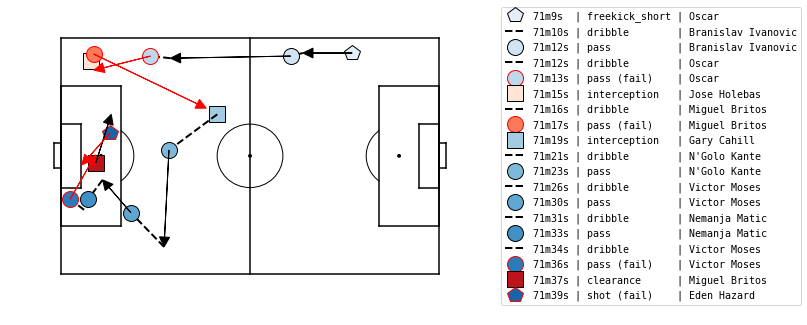

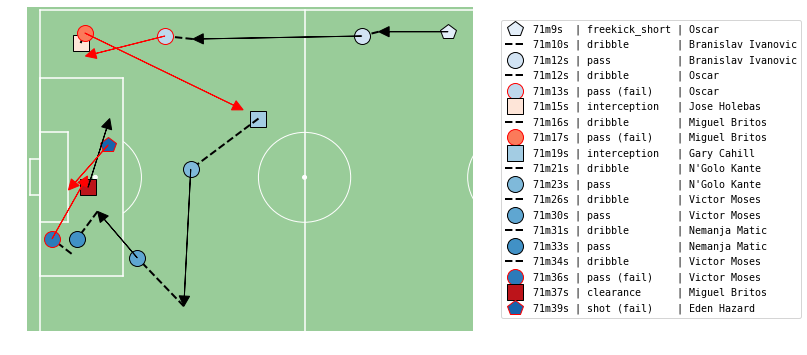

In [7]:
start = 29411
delta = 19
for i in range(1):
    phase = actions[start+i*delta:start+delta+i*delta].copy()
    phase["team"] = phase.full_name
    phase["player"] = phase.soccer_name
    phase = phase[["team","player","time_seconds","type_name","result","start_x","start_y","end_x","end_y"]]

    # Full field
    mps.actions(phase,figsize = 8)

    ## Zoomed in
    mps.actions(phase,color="green",zoom=True,figsize=8)

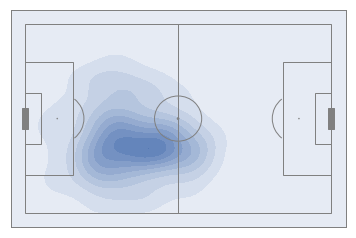

In [17]:
shot_chart(x,y,kind="kde")

In [9]:
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
# from bokeh.plotting import figure, ColumnDataSource
# from bokeh.models import HoverTool
from math import pi


sns.set_style('white')
sns.set_color_codes()

# In meters
PITCH_WIDTH = 68.0
PITCH_LENGTH = 105.0

def draw_pitch(ax=None, color='gray', lw=1, despine=False):
    """Returns an axes with a basketball court drawn onto to it.
    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example the center of the
    hoop is located at the (0,0) coordinate.  Twenty-two feet from the left of
    the center of the hoop in is represented by the (-220,0) coordinates.
    So one foot equals ±10 units on the x and y-axis.
    Parameters
    ----------
    ax : Axes, optional
        The Axes object to plot the court onto.
    color : matplotlib color, optional
        The color of the court lines.
    lw : float, optional
        The linewidth the of the court lines.
    Returns
    -------
    ax : Axes
        The Axes object with the court on it.
    """

    #Create figure
    if ax is None:
        ax = plt.gca()

    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_xlim(-5, PITCH_LENGTH + 5)
    ax.set_ylim(-5, PITCH_WIDTH + 5)

    # Create an empty array of strings with the same shape as the meshgrid, and
    # populate it with two colors in a checkerboard pattern.
    # ylen = int(PITCH_LENGTH/10)
    # xlen = int(PITCH_WIDTH/10)
    # colortuple = ((86,176,0, 100), (99,201,0, 100))
    # colors = np.empty((xlen,ylen,4), dtype=int)
    # for y in range(ylen):
    #     for x in range(xlen):
    #         colors[x, y] = colortuple[(x + y) % len(colortuple)]
    # x0, x1 = ax.get_xlim()
    # y0, y1 = ax.get_ylim()
    # ax.imshow(colors, extent=[x0, x1, y0, y1], aspect='auto')

    # size of the pitch is 120, 80

    #Pitch Outline & Centre Line
    outerLinesLeftHalf = Rectangle((0, 0), PITCH_LENGTH/2, PITCH_WIDTH, linewidth=lw, color=color, fill=False)
    ax.add_patch(outerLinesLeftHalf)
    outerLinesRightHalf = Rectangle((PITCH_LENGTH/2, 0), PITCH_LENGTH/2, PITCH_WIDTH, linewidth=lw, color=color, fill=False)
    ax.add_patch(outerLinesRightHalf)

    #Left Penalty Area
    leftPenaltyArea = Rectangle((0, PITCH_WIDTH/2 - 20.16), 16.5, 40.32, linewidth=lw, color=color, fill=False)
    ax.add_patch(leftPenaltyArea)

    #Right Penalty Area
    rightPenaltyArea = Rectangle((PITCH_LENGTH-16.5, PITCH_WIDTH/2 - 20.16), 16.5, 40.32, linewidth=lw, color=color, fill=False)
    ax.add_patch(rightPenaltyArea)

    #Left 6-yard Box
    leftSixYardBox = Rectangle((0, PITCH_WIDTH/2 - 9.16), 5.5, 18.32, linewidth=lw, color=color, fill=False)
    ax.add_patch(leftSixYardBox)

    #Right 6-yard Box
    rightSixYardBox = Rectangle((PITCH_LENGTH-5.5, PITCH_WIDTH/2 - 9.16), 5.5, 18.32, linewidth=lw, color=color, fill=False)
    ax.add_patch(rightSixYardBox)

    #Left goal
    leftGoal = Rectangle((-1, PITCH_WIDTH/2 - 3.66), 2, 7.32, linewidth=lw, color=color, fill=True)
    ax.add_patch(leftGoal)

    #Right goal
    rightGoal = Rectangle((PITCH_LENGTH-1, PITCH_WIDTH/2 - 3.66), 2, 7.32, linewidth=lw, color=color, fill=True)
    ax.add_patch(rightGoal)

    #Prepare Circles
    centreCircle = Circle((PITCH_LENGTH/2, PITCH_WIDTH/2), 8.1, color=color, fill=False)
    ax.add_patch(centreCircle)
    centreSpot = Circle((PITCH_LENGTH/2, PITCH_WIDTH/2), 0.3, color=color)
    ax.add_patch(centreSpot)
    leftPenSpot = Circle((11, PITCH_WIDTH/2), 0.1, color=color)
    ax.add_patch(leftPenSpot)
    rightPenSpot = Circle((PITCH_LENGTH-11, PITCH_WIDTH/2), 0.1, color=color)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((11,PITCH_WIDTH/2), height=18.3, width=18.3, angle=0, theta1=310, theta2=50, color=color)
    ax.add_patch(leftArc)
    rightArc = Arc((PITCH_LENGTH-11, PITCH_WIDTH/2), height=18.3, width=18.3, angle=0, theta1=130, theta2=230, color=color)
    ax.add_patch(rightArc)


    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(lw)
        ax.spines[spine].set_color(color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        
    return ax


def shot_chart(x, y, kind="scatter", title="", color="b", cmap=None,
               xlim=(0,120), ylim=(0,80),
               court_color="gray", court_lw=1, outer_lines=False,
               flip_court=False, kde_shade=True, gridsize=None, ax=None,
               despine=False, **kwargs):
    """
    Returns an Axes object with player shots plotted.
    Parameters
    ----------
    x, y : strings or vector
        The x and y coordinates of the shots taken. They can be passed in as
        vectors (such as a pandas Series) or as columns from the pandas
        DataFrame passed into ``data``.
    data : DataFrame, optional
        DataFrame containing shots where ``x`` and ``y`` represent the
        shot location coordinates.
    kind : { "scatter", "kde", "hex" }, optional
        The kind of shot chart to create.
    title : str, optional
        The title for the plot.
    color : matplotlib color, optional
        Color used to plot the shots
    cmap : matplotlib Colormap object or name, optional
        Colormap for the range of data values. If one isn't provided, the
        colormap is derived from the valuue passed to ``color``. Used for KDE
        and Hexbin plots.
    {x, y}lim : two-tuples, optional
        The axis limits of the plot.
    court_color : matplotlib color, optional
        The color of the court lines.
    court_lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If ``True`` the out of bound lines are drawn in as a matplotlib
        Rectangle.
    flip_court : boolean, optional
        If ``True`` orients the hoop towards the bottom of the plot.  Default
        is ``False``, which orients the court where the hoop is towards the top
        of the plot.
    kde_shade : boolean, optional
        Default is ``True``, which shades in the KDE contours.
    gridsize : int, optional
        Number of hexagons in the x-direction.  The default is calculated using
        the Freedman-Diaconis method.
    ax : Axes, optional
        The Axes object to plot the court onto.
    despine : boolean, optional
        If ``True``, removes the spines.
    kwargs : key, value pairs
        Keyword arguments for matplotlib Collection properties or seaborn plots.
    Returns
    -------
     ax : Axes
        The Axes object with the shot chart plotted on it.
    """

    if ax is None:
        ax = plt.gca()

    if cmap is None:
        cmap = sns.light_palette(color, as_cmap=True)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_title(title, fontsize=18)

    draw_pitch(ax, color=court_color, lw=court_lw)

    if kind == "scatter":
        ax.scatter(x, y, c=color, **kwargs)

    elif kind == "kde":
        sns.kdeplot(x, y, shade=kde_shade, cmap=cmap, ax=ax, **kwargs)
        ax.set_xlabel('')
        ax.set_ylabel('')

    elif kind == "hex":
        if gridsize is None:
            # Get the number of bins for hexbin using Freedman-Diaconis rule
            # This is idea was taken from seaborn, which got the calculation
            # from http://stats.stackexchange.com/questions/798/
            from seaborn.distributions import _freedman_diaconis_bins
            x_bin = _freedman_diaconis_bins(x)
            y_bin = _freedman_diaconis_bins(y)
            gridsize = int(np.mean([x_bin, y_bin]))

        ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)

    else:
        raise ValueError("kind must be 'scatter', 'kde', or 'hex'.")

    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(court_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

def pass_chart(x, y, kind="scatter", title="", color="b", cmap=None,
               xlim=(0,120), ylim=(0,80),
               court_color="gray", court_lw=1, outer_lines=False,
               flip_court=False, kde_shade=True, gridsize=None, ax=None,
               despine=False, **kwargs):
    """
    Returns an Axes object with player shots plotted.
    Parameters
    ----------
    x, y : strings or vector
        The x and y coordinates of the shots taken. They can be passed in as
        vectors (such as a pandas Series) or as columns from the pandas
        DataFrame passed into ``data``.
    data : DataFrame, optional
        DataFrame containing shots where ``x`` and ``y`` represent the
        shot location coordinates.
    kind : { "scatter", "kde", "hex" }, optional
        The kind of shot chart to create.
    title : str, optional
        The title for the plot.
    color : matplotlib color, optional
        Color used to plot the shots
    cmap : matplotlib Colormap object or name, optional
        Colormap for the range of data values. If one isn't provided, the
        colormap is derived from the valuue passed to ``color``. Used for KDE
        and Hexbin plots.
    {x, y}lim : two-tuples, optional
        The axis limits of the plot.
    court_color : matplotlib color, optional
        The color of the court lines.
    court_lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If ``True`` the out of bound lines are drawn in as a matplotlib
        Rectangle.
    flip_court : boolean, optional
        If ``True`` orients the hoop towards the bottom of the plot.  Default
        is ``False``, which orients the court where the hoop is towards the top
        of the plot.
    kde_shade : boolean, optional
        Default is ``True``, which shades in the KDE contours.
    gridsize : int, optional
        Number of hexagons in the x-direction.  The default is calculated using
        the Freedman-Diaconis method.
    ax : Axes, optional
        The Axes object to plot the court onto.
    despine : boolean, optional
        If ``True``, removes the spines.
    kwargs : key, value pairs
        Keyword arguments for matplotlib Collection properties or seaborn plots.
    Returns
    -------
     ax : Axes
        The Axes object with the shot chart plotted on it.
    """

    if ax is None:
        ax = plt.gca()

    if cmap is None:
        cmap = sns.light_palette(color, as_cmap=True)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_title(title, fontsize=18)

    draw_pitch(ax, color=court_color, lw=court_lw)

    if kind == "scatter":
        for i in range(len(x)):
            ax.plot((x.values[i,0],y.values[i,0]), (x.values[i,1],y.values[i,1]), c=color, **kwargs)
            ax.plot(x.values[i, 0], x.values[i, 1],"o", color=color)

    elif kind == "kde":
        sns.kdeplot(x, y, shade=kde_shade, cmap=cmap, ax=ax, **kwargs)
        ax.set_xlabel('')
        ax.set_ylabel('')

    elif kind == "hex":
        if gridsize is None:
            # Get the number of bins for hexbin using Freedman-Diaconis rule
            # This is idea was taken from seaborn, which got the calculation
            # from http://stats.stackexchange.com/questions/798/
            from seaborn.distributions import _freedman_diaconis_bins
            x_bin = _freedman_diaconis_bins(x)
            y_bin = _freedman_diaconis_bins(y)
            gridsize = int(np.mean([x_bin, y_bin]))

        ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)

    else:
        raise ValueError("kind must be 'scatter', 'kde', or 'hex'.")

    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(court_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax